In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import tensorflow_probability as tfp
import cv2

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,Dropout

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Check if the dataset has already been downloaded
try:
    # Attempt to load the dataset from the local directory
    dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'], data_dir="./")
    print("Dataset loaded from local directory.")
except tfds.core.DatasetNotFoundError:
    # If the dataset is not found locally, download it to the current directory
    dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])
    print("Dataset downloaded and loaded.")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling malaria/1.0.0.incompleteMQH1SS/malaria-train.tfrecord*...:   0%|          | 0/27558 [00:00<?, ? exam…

Dataset malaria downloaded and prepared to ./malaria/1.0.0. Subsequent calls will reuse this data.
Dataset loaded from local directory.


In [ ]:
def splits(dataset,Train_Ratio,Val_Ratio,Test_Ratio):
  size=len(dataset)
  train_dataset=dataset.take(int(Train_Ratio*size))
  val_test_dataset=dataset.skip(int(Train_Ratio*size))
  val_dataset=val_test_dataset.take(int(Val_Ratio*size))
  test_dataset=val_test_dataset.skip(int(Val_Ratio*size))
  return train_dataset,val_dataset,test_dataset

In [ ]:
Train_Ratio=0.8
Val_Ratio=0.1
Test_Ratio=0.1
train_dataset,val_dataset,test_dataset=splits(dataset[0],Train_Ratio,Val_Ratio,Test_Ratio)

In [ ]:
print(list(train_dataset.take(1)))

[(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)]


**Dataset Visualization**

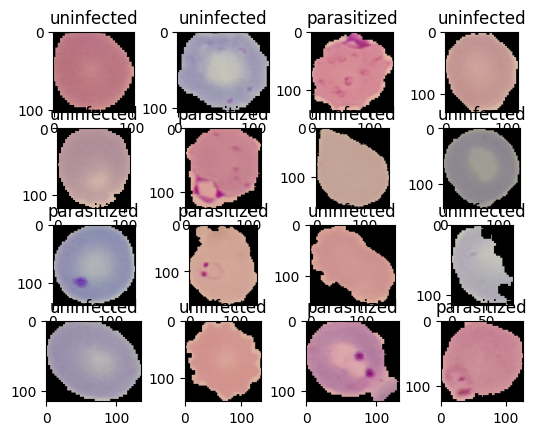

In [ ]:
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

**Data processing**

in the case of image data , the choice of wheither to standarize or normalize goes to wheither the pixels of the images revolve around certain mean value then we anna standarize otherwise we're going to normalize

In [ ]:
Im_Size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(Im_Size,Im_Size))/255.0,label

In [ ]:
train_dataset=train_dataset.map(resize_rescale)
# map method applies certain function given in the arguments to all elements of the data set


<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset=val_dataset.map(resize_rescale)

In [ ]:
test_dataset=test_dataset.map(resize_rescale)

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset=val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset=test_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

** MODEL CREATION **

**Sequential API**

In [ ]:
Im_Size=224
model =tf.keras.Sequential([
    InputLayer(input_shape=(Im_Size,Im_Size,3)),
    Conv2D(filters =6,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters =16,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100,activation='relu'),
    BatchNormalization(),
    Dense(10,activation='relu'),
    BatchNormalization(),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

**Functional Api**

In [ ]:
    func_input=Input(shape=(Im_Size,Im_Size,3),name='Input Image')
    x=Conv2D(filters =6,kernel_size=3,strides=1,padding='valid',activation='relu')(func_input)
    x=BatchNormalization()(x)
    x=MaxPool2D(pool_size=2,strides=2)(x)
    x=Conv2D(filters =16,kernel_size=3,strides=1,padding='valid',activation='relu')(x)
    x=BatchNormalization()(x)
    output=MaxPool2D(pool_size=2,strides=2)(x)
    feature_extractor_model=Model(func_input,output,name='Feature_Extractor')
    feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)

In [ ]:
    func_input=Input(shape=(Im_Size,Im_Size,3),name='Input Image')
    x=feature_extractor_model(func_input)
    x=Flatten()(x)
    x=Dense(100,activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dense(10,activation='relu')(x)
    x=BatchNormalization()(x)
    func_output=Dense(1,activation='sigmoid')(x)
    model=Model(func_input,func_output,name='model')
    model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010  

**Model Subclassing**

In [ ]:

class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

    self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D (pool_size = pool_size, strides= 2*strides)

  def call(self, x, training):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

In [ ]:
func_input = Input(shape = (224, 224, 3), name = "Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Feature  (None, 54, 54, 16)        1488      
 Extractor)                                                      
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_10 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_7 (Dense)             (None, 10)                

In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = "relu")
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation = "relu")
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation = "sigmoid")

  def call(self, x, training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

lenet_sub_classed = LenetModel()
lenet_sub_classed(tf.zeros([1,224,224,3]))
lenet_sub_classed.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  4665700   
                                                                 
 batch_normalization_14 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_10 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_15 (Ba  multiple                  

**Error sanctioning**

for error sanctioning binary classification problems we often use binary crossentropy loss

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy')

In [ ]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5
551/689 [======================>.......] - ETA: 6s - loss: 0.2933 - accuracy: 0.8861

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'])
plt.show()

**Model evaluating and testing**

In [ ]:
model.evaluate(test_dataset)

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i ,(image,label) in enumerate(test_dataset.take(9)):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not (model1.predict(image)[0][0])))
  plt.axis('off')

**Saving and loading the model**

In [ ]:
model.save('my_model.h5')  # Save the entire model to a HDF5 file


In [ ]:




# Path to the saved model file
model_path = '/content/my_model (2).h5'

# Load the model
model1 = tf.keras.models.load_model(model_path)

# Now you can use the model for inference


**Sequential API**
The Sequential API is the simplest way to build a model in Keras, especially when your model consists of a linear stack of layers (i.e., one layer following another). It's called "sequential" because you build the model layer by layer in a sequential manner.     
**Functional API**
The Functional API is more flexible and powerful than the Sequential API. It allows you to define complex models that involve multiple inputs, multiple outputs, shared layers, and non-linear connections between layers. With the Functional API, you can create directed acyclic graphs of layers.          
**Subclassing** the tf.keras.Model class provides the highest level of flexibility and customization. You can define your model architecture by writing custom classes that inherit from tf.keras.Model and override the __init__ method to create layers and the call method to define the forward pass computation.

**Custom layers**

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self,output_units,activation):
    super(NeuralearnDense,self).__init__()
    self.output_units=output_units
    self.activation=activation
  def build(self,input_features_shape):
    self.w=self.add_weight(shape=(input_features_shape[-1],self.output_unit),initializer="random_normal",trainable=True)
    self.b=self.add_weights(shape=(self.output_units,),initializer="random_normal",trainable=True)
  def call(self,input_features):
    if self.activation=="relu":
      return tf.math.relu(tf.matmul(input_features,self.w)+self.b)
    elif self.activation=="sigmoid":
      return tf.math.sigmoid(tf.matmul(input_features,self.w)+self.b)
    else:
      return tf.matmul(input_features,self.w)+self.b

**Evaluating Classification Models**

Sometimes using the accuracy as a metric is not pretty good in evaluating our model. we can instead introduce the FP FN scores for a better understanding of our model performance  

Precision= TP/TP+FP

Recall= TP/TP+FN


Accuracy=TN+TP/TN+TP+FN+FP

FM-SCORE=2PR/P+R

SPECIFITY=TN/TN+FP

**Callbacks**

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    print("for Epoch Number {} the model has a loss of {}\n".format(epoch,logs["loss"]))

**CSV LOGGER**

In [ ]:
csv_callback=CSVLogger(
    'logs.csv',separator=',',append=False
)

**early stopping**

In [ ]:
es_callback=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

**learningRateschedular**

The learning rate is a hyperparameter that controls the step size at which the model's parameters (weights and biases) are updated during training. It determines how quickly or slowly the model learns from the training data.
Learning Rate Schedulers: Learning rate schedulers adjust the learning rate during training based on predefined schedules. Common learning rate schedules include decreasing the learning rate exponentially, based on a step function, or using a cyclic learning rate schedule. Learning rate schedules can help improve convergence and prevent overfitting.

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr *tf.math.exp(-0.1)
# the learning rate decreases exponentioally after 10 epochs
schedular_callabck=LearningRateScheduler(scheduler,verbose=1)

**model checkpointing**

Model Checkpointing: Save the model's weights during training, typically after each epoch or when the model achieves the best performance on a validation set.

In [ ]:
checkpoint_callabck=ModelCheckpoint(
    'checkpoints/',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=3,
    initial_value_threshold=None
)

**ReduceLROnPlateau**

In [ ]:
plateau_callback=ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0,
    **kwargs
)

**Mitigating(reducing) Overfitting and Underfitting**

Overfitting is caused generally when you are trying to build a big model with a lot of parameters only having a small dataset. there has to be a balance between the size of the datasset and the model . but not only the size of the dataset we can talk also about the quality of that dataset

**batch sizes**

training with large minibatches is bad for your health . More importantly , it's bad for your test error . Fellas don't let your friend useminibatches larger than 32 ~Yann Lecun~

**Dropout**

Overfitting occurs when a model learns to memorize the training data instead of learning the underlying patterns, resulting in poor performance on unseen data. Dropout helps to address this issue by randomly dropping (i.e., setting to zero) a certain proportion of neurons during training.

The Dropout layer is typically applied to the input or hidden layers of a neural network. During each training iteration, individual neurons in the layer are probabilistically "dropped out" with a certain probability, meaning their outputs are set to zero. This process is done independently for each training example and helps to prevent neurons from relying too much on specific inputs or co-adapting with each other.

By randomly dropping neurons, Dropout effectively reduces the model's capacity and forces it to learn more robust and generalizable features. It acts as a form of ensemble learning, where different subsets of neurons are trained on different parts of the data, leading to a more diverse and generalized model.

In [ ]:
Dropout(
    rate, noise_shape=None, seed=None, **kwargs
)
# we should plug it into our model

**Regularization** works by adding a penalty term to the loss function during training. This penalty term discourages the model from learning overly complex patterns in the training data that may not generalize well to unseen data.

we can always refer to tensorflow to call regularizers like L1 L2 ....

**DATA AUGMENTATION**

In [ ]:
def visualise(original,augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.subplot(1,2,1)
  plt.imshow(augmented)

In [ ]:
original_image,label=next(iter(train_dataset))

augmented_image=tf.image.flip_left_right(
    original_image
)


**Mixup data augmentation**

In [ ]:
def mixup (train_dataset_1,train_dataset_2):
  (image_1,label_1),(image_2,label_2)=train_dataset_1,train_dataset_2
  lamda =tfp.distributions.Beta(0.2,0.2)
  image = lamda*image_1+(1-lamda)*image_2
  label = lamda*tf.cast(label_1,dtype=tf.float32)+(1-lamda)*lamda*tf.cast(label_2,dtype=tf.float32)
  return image,label

**custom loss and metrics**